# Example notebook for basic MD trajectory analysis
This notebook is intended to give an idea of what is a common approach on the basic analysis of some equilibration trajectories coming from Molecular Dynamics (MD) simulations.

In [1]:
# base modules 
import os
import numpy as np
# specialized modules
from MDAnalysis import Universe
from MDAnalysis.analysis.rms import RMSD, RMSF, rmsd
from MDAnalysis.analysis import align
from MDAnalysis.lib.mdamath import make_whole
from MDAnalysis.analysis import contacts
from MDAnalysis.analysis.distances import dist
# visualization modules
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_context("notebook")
#sns.set_context("poster", font_scale=2.2, rc={"lines.linewidth": 5.5})
# For visualizing trajectories
import nglview as nv
#import mdtraj as md
# For pymol - read structure and do things with it :)
import pymol
# Style sns
sns.set_style("ticks")
sns.despine()

## Data structure

In this simple example we have 5 replicas of the same system, that is, 5 different trajectories for the same protein domain. Using the `MDAnalysis` terminology, a `universe` is a protein structure/topology and trajectory set. Then, for this exercise, we will be defining `multiverse` objects which are just lists of universes.

To give an idea how is the data stored in the filesystem this is what the tree structure looks like:

```bash
➜ tree sample_data  
sample_data
├── 1
│   ├── npt.gro
│   ├── run.xtc
│   └── traj_centered.xtc
├── 2
│   ├── npt.gro
│   ├── run.xtc
│   └── traj_centered.xtc
├── 3
│   ├── npt.gro
│   ├── run.xtc
│   └── traj_centered.xtc
├── 4
│   ├── npt.gro
│   ├── run.xtc
│   └── traj_centered.xtc
└── 5
    ├── npt.gro
    ├── run.xtc
    └── traj_centered.xtc
```

Where `npt.gro` is the GROMACS structure file and `traj_centered.xtc` is the trajectory file of interest.

## Common metrics and basic function implementations for them

We will be using some well-known and commonly used metrics to study the stability of the equilibrium MD simulations. Specifically we will be using the radius of gyration ($R_g$), root mean square deviation ($\mathrm{RMSD}$) and root mean square fluctuations ($\mathrm{RMSF}$). Defined as

* $R_g = \sqrt{\frac{\sum_i m_i \mathbf{r}_i^2}{\sum_i m_i}}$

* $\mathrm {RMSD}(t) ={\sqrt {{\frac {1}{N}}\sum _{i=1}^{N}\delta_{i}^{2}(t)}}$ Which involves an ensemble average for each time frame $t$.

* $\mathrm {RMSF}(i) = {\sqrt {{\frac {1}{F}}\sum _{t=1}^{N}\delta_{t}^{2}(i)}}$ Involves the time-averaged fluctuation for a residue $i$.

The following function definitions use the routines from `MDAnalysis` to compute these quantities, but are written with the "multiverse" structure in mind.

In [2]:
# Reading helices from structure
def get_helices(pdb_path, basename="protein"):
    """
    Function that returns the helices residues indices from a PDB structure
    file. It uses PyMol to select by secondary structure.
    """
    # Loading pdb file
    # Selecting helices and saving to pdb file
    # TODO: Check if can be done without writing an extra pdb file
    # Delete averything first
    pymol.cmd.delete("all")
    pymol.cmd.load(pdb_path, basename)
    pymol.cmd.select(basename + "_helices", selection="ss H")
    pymol.cmd.save(filename=os.path.dirname(pdb_path)+"/helices.pdb", selection=basename+ "_helices")
    
    # Reading residues indices in helices
    #helices_indices = !cat dbl1_path"run/1/helices.pdb" | awk '{print $6}' 
    # Get sixth column (indices column) from helices pdb
    # TODO: this assumes the file is "helices.pdb", make it customizable.
    helices_indices = [int(x.split()[4]) for x in open(os.path.dirname(pdb_path)+"/helices.pdb").readlines() 
                      if "ATOM" in x.split()[0]]
    return helices_indices

def mda_list2selstr(indices_list):
    """
    Function that builds a selection string for MDAnalysis given a list of
    index for residues.
    """
    # Building selection string to pass to MDAnalysis
    sel_str = "backbone and (resid "
    for resid in helices_indices:
        sel_str += str(resid)+" "
    return sel_str+")"

def get_rgyr(multiverse, save=False):
    """
    Function that computes the radius of gyration given a multiverse of trajectories and 
    optionally, saves the results in textfiles called rgyr_centered.dat
    """
    # Calculating radius of gyration and pulling groups/terminals positions
    for index,universe in enumerate(multiverse):
        protein = universe.select_atoms("protein")
        r_gyr_ = []  # temporary list to store r_gyr data
        for ts in universe.trajectory:
            tstep = universe.trajectory.time
            r_gyr_.append((tstep, protein.radius_of_gyration()))  # appending time step, rgyr data for each frame/step
        r_gyr_ = np.array(r_gyr_)  # Converting to numpy data
        if save:
            tmp_path_ = domain_paths[domain_name_][index]
            #print(tmp_path_)
            np.savetxt(tmp_path_ + "/rgyr_centered.dat", r_gyr_)

def get_rmsd(multiverse, save=False, select_str="backbone"):
    """
    Function that computes the RMSD given a multiverse of trajectories and 
    optionally, saves the results in textfiles called rmsd_centered.dat in
    each replica directory
    """
    # Computing RMSD
    for index,universe in enumerate(multiverse):
        # Make a copy of universe to act as reference
        reference = universe.copy()
        R = RMSD(universe, reference,
                 select=select_str,
                 center=True,
                 superposition=True,
                 verbose=True)
        R.run()
        # Save file
        if save:
            np.savetxt(f"{domain_paths[domain_name_][index]}/rmsd_centered.dat", R.rmsd)
        
def get_rmsf(multiverse, save=False):
    """
    Function that computes the RMSF given a multiverse of trajectories and 
    optionally, saves the results in textfiles called rmsd_centered.dat in
    each replica directory
    """
    for index,universe in enumerate(multiverse):
        calphas = universe.select_atoms("protein and backbone")
        rmsfer = RMSF(calphas, verbose=True).run()
        if save:
            # TODO: Not to get domain_name_ from global variable
            np.savetxt(f"{domain_paths[domain_name_][index]}/rmsf_centered.dat", np.dstack((calphas.resnums, rmsfer.rmsf))[0])
    
def get_last_frame(universe, select_str="protein", savefile=None):
    """
    Function that extracts the last frame from a trajectory, given a MDAanalysis universe.
    Optionally it can save the frame in a PDB file.
    """
    # Get trajectory and set it to last frame
    traj = universe.trajectory
    traj[-1]  # get last frame
    print(f"Last frame is {traj.frame}.")  # sanity check msg 
    # Get atomgroup
    atomgroup = universe.select_atoms(select_str)
    # Save file if specified
    if savefile is not None:
        print(f"Atom group snapshot saved in {savefile}")
        atomgroup.write(savefile)
    return atomgroup

## Setting up paths and base data structures

In [3]:
# Setting up paths
workingdir = "./sample_data"  # working dir / basepath
gro_filename =  "npt.gro"  # Filename for the structure/topology file
traj_filename = "traj_centered.xtc"  # File name for the trajectory file 

This notebook is intended to work with multiple directories having the structure depicted above, but we will be using only one for this example

In [4]:
# Getting all paths for all domains
domain_name_list = ["dom1"]  # Just one domain for example
# For multiple domains
#domain_name_list =  ["dom1", "dom2", "dom3", "dom4", "dom5", "dom6"]
domain_paths = {}  # Creating empty dictionary to store the domain paths
sel_strings = {}  # Empty dictionary to store helical residues select strings
for domain in domain_name_list:
    domain_paths[domain] = []
    pdb_path = f"{workingdir}/{domain}/conf.pdb"  # pdb path for sel_strings
    helices_indices = get_helices(pdb_path, basename=domain)  # select strings for each domain
    sel_strings[domain] = mda_list2selstr(helices_indices)
    for replica in range(5):
        domain_paths[domain].append(f"{workingdir}/{domain}/{replica+1}")

 PyMOL not running, entering library mode (experimental)


In [5]:
# Example of replica paths in dictionary
domain_paths["dom1"]

['./sample_data/dom1/1',
 './sample_data/dom1/2',
 './sample_data/dom1/3',
 './sample_data/dom1/4',
 './sample_data/dom1/5']

In [6]:
# Example of select string for residues in helices
sel_strings["dom1"]

'backbone and (resid 20 21 22 23 24 28 29 30 31 32 33 34 35 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 278 279 280 291 292 293 294 295 296 297 298 299 304 305 306 307 311 312 313 315 316 317 318 319 320 345 346 347 )'

## Dom1

Here we will be preforming the analysis of the 5 replicas for the first domain, called `dom1`. The basic steps are as follows:

1. Building `multiverse` with each trajectory for each replica.
2. [Visualizing](#Visualization) trajectory as first direct check.
3. [Radius of Gyration](#Radius-of-gyration:-Computation-and-results) computation and results.
4. [RMSD](#RMSD) computation and results.
5. [RMSF](#RMSF) computation and results.

In [7]:
# Building multiverse from topology and trajectory mdanalysis universes
dom1_multiverse = []  # List to store universes objects. One per replica.
domain_name_ = "dom1"  # String of domain name. Just to make things easier to replicate later, just by changing this variable.
for replica in range(5):
    tmp_gro_path = f"{domain_paths[domain_name_][replica]}/{gro_filename}"
    tmp_traj_path_ = f"{domain_paths[domain_name_][replica]}/{traj_filename}"
    dom1_multiverse.append(Universe(tmp_gro_path, tmp_traj_path_))

### Visualization
It is recommended to always visualize the trajectory first, to check for obvious signs of issues or problems. One way to do it is using the `nglviewer` tool.

In [8]:
# Visualizing trajectory - Interactive
protein = dom1_multiverse[0].select_atoms("protein")
w = nv.show_mdanalysis(protein)
w

/home/ijpulidos/anaconda3/envs/thesis_env/lib/python3.7/site-packages/MDAnalysis/coordinates/PDB.py:902: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  "".format(attrname, default))
/home/ijpulidos/anaconda3/envs/thesis_env/lib/python3.7/site-packages/MDAnalysis/coordinates/PDB.py:902: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  "".format(attrname, default))
/home/ijpulidos/anaconda3/envs/thesis_env/lib/python3.7/site-packages/MDAnalysis/coordinates/PDB.py:902: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  "".format(attrname, default))
/home/ijpulidos/anaconda3/envs/thesis_env/lib/python3.7/site-packages/MDAnalysis/coordinates/PDB.py:902: UserWarning: Found no information for attr: 'tempfactors' Using default value of '0.0'
  "".format(attrname, default))


NGLWidget(max_frame=4074)

In [9]:
w.render_image()  # Static image

Image(value=b'', width='99%')

### Radius of gyration: Computation and results

This section is where $R_g$ is computed, stored in a text file called `rgyr_centered.dat` in each replica subdirectory to be reused without the need of computing the quantity again, and from that file both the time evolution and the probability distribution are plotted.

In [10]:
# Compute radius of gyration
get_rgyr(dom1_multiverse, save=True)

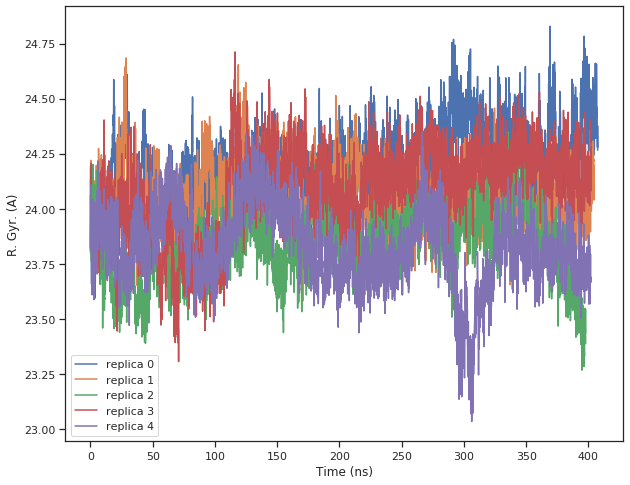

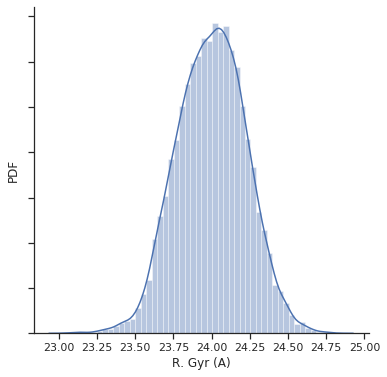

In [11]:
# Plotting the results - from file - RGYR
plt.figure(figsize=(10,8))
plt.xlabel("Time (ns)")
plt.ylabel("R. Gyr. (A)")
rgyr_whole = []
for replica in range(5):
    filename = "rgyr_centered.dat"
    tmp_path_ = f"{domain_paths[domain_name_][replica]}/{filename}"
    rgyr_tmp_ = np.loadtxt(tmp_path_)
    rgyr_whole.append(rgyr_tmp_)
    plt.plot(rgyr_tmp_[:,0]/1000, rgyr_tmp_[:,1], label="replica {}".format(replica))
plt.legend()  # Draw legend
# Concatenate in a single array
rgyr_whole = np.concatenate(rgyr_whole)
# Plot rgyr histogram
plt.figure(figsize=(6,6))
plt.xlabel("R. Gyr (A)")
plt.ylabel("PDF")
A = sns.distplot(rgyr_whole[:,1])
A.set(yticklabels=[])
sns.despine()

Overall good stabilization of the $R_g$ over the complete trajectory (it is not "blowing out"). Narrow "well-behaved" distribution for its values.

### RMSD

As with $R_g$, the RMSD is computed and stored in a text file to be used for plotting without the need to be doing the computation everytime.

In [12]:
# Compute RMSD
get_rmsd(dom1_multiverse, save=True, select_str=sel_strings[domain_name_])

RMSD  2.25 A at frame  4075/4075  [100.0%]
RMSD  2.04 A at frame  4048/4048  [100.0%]
RMSD  2.19 A at frame  3978/3978  [100.0%]
RMSD  2.29 A at frame  4023/4023  [100.0%]
RMSD  2.35 A at frame  4021/4021  [100.0%]


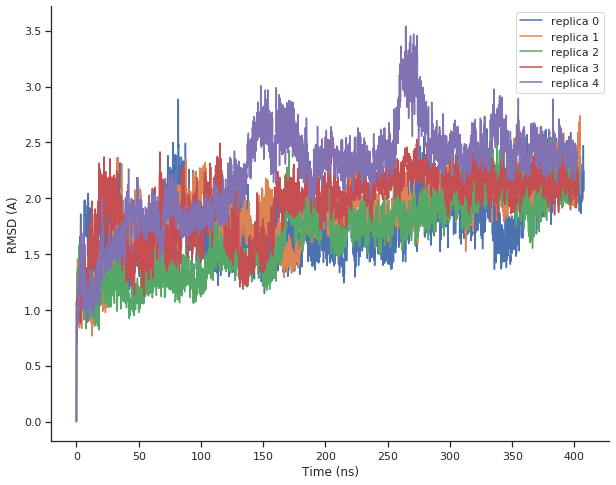

In [13]:
# Plotting RMSD
plt.figure(figsize=(10,8))
plt.xlabel("Time (ns)")
plt.ylabel("RMSD (A)")
#plt.ylim(0, 12)
for replica in range(5):
    filename = "rmsd_centered.dat"
    tmp_path_ = f"{domain_paths[domain_name_][replica]}/{filename}"
    rmsd_tmp_ = np.loadtxt(tmp_path_)
    plt.plot(rmsd_tmp_[:,1]/1000, rmsd_tmp_[:,2], label="replica {}".format(replica))
plt.legend()  # Draw legend
sns.despine()

Maybe more time is needed for the relaxation/equilibration. But still the RMSD is showing signs of stabilization, having overall $< 3\mathrm{A}$ values and showing convergence.

### RMSF

In [14]:
# Compute RMSF
get_rmsf(dom1_multiverse, save=True)

Step  4075/4075 [100.0%]
Step  4048/4048 [100.0%]
Step  3978/3978 [100.0%]
Step  4023/4023 [100.0%]
Step  4021/4021 [100.0%]


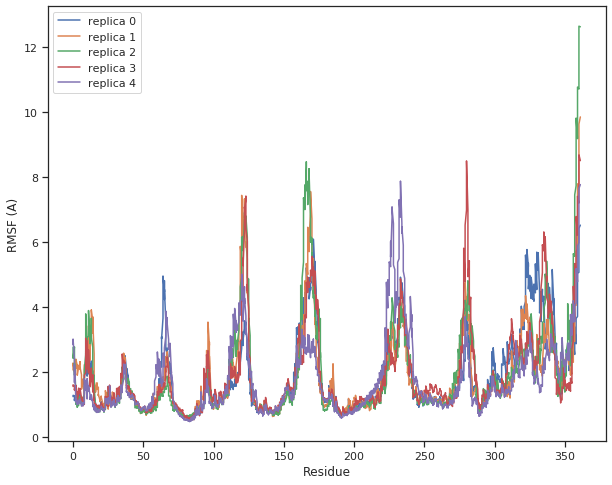

In [15]:
# Plotting
plt.figure(figsize=(10,8))
plt.xlabel("Residue")
plt.ylabel("RMSF (A)")
for replica in range(5):
    filename = "rmsf_centered.dat"
    tmp_path_ = f"{domain_paths[domain_name_][replica]}/{filename}"
    rmsd_tmp_ = np.loadtxt(tmp_path_)
    plt.plot(rmsd_tmp_[:,0], rmsd_tmp_[:,1], label="replica {}".format(replica))
plt.legend()  # Draw legend

Residues showing larger fluctuations corresponding to coil or loops in the domain. Consistent in all replicas.